# V928 Tau - Eclipse

In this notebook we take the output of the stellar variation notebook and model the eclipse. We do this using the <strong>pyPplusS</strong> package designed by Rein & Odir 2019. We make the assumption that the two components of the binary are identical and thus that the deblended light curve just doubles the fluctuations about 1.

In [1]:
import emcee
import logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import mcmc, eclipse

%matplotlib inline

## Load the Data

In [2]:
time, flux_b, flux, error = eclipse.load_data('data/photometry/eclipse_lightcurve.txt')

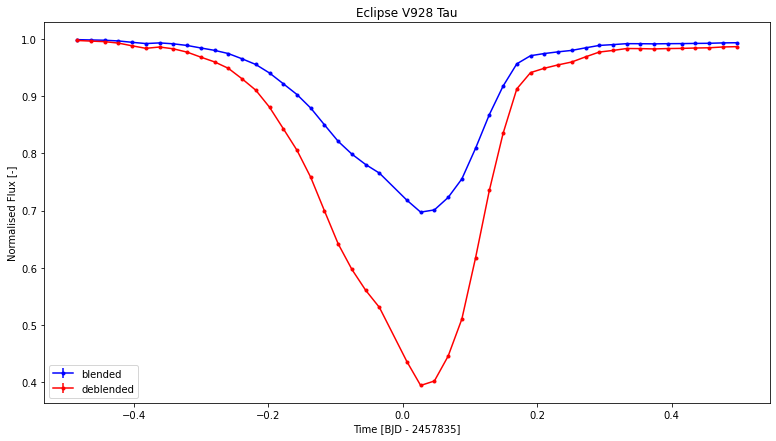

In [3]:
plt.figure(figsize=(13, 7))
plt.title('Eclipse V928 Tau')
plt.xlabel('Time [BJD - 2457835]')
plt.ylabel('Normalised Flux [-]')
plt.errorbar(time, flux_b, yerr=error, fmt='.', color='b', ls='-', label='blended')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-', label='deblended')
plt.legend()
plt.show()

## Model Set-up

This takes the <strong>disk_model()</strong> function from <strong>eclipse_functions</strong>, and creates sub-functions for:

* soft_fuzzy_disk --> n.a.
* hard_fuzzy_disk --> tau_disk = 1
* soft_single_disk --> redge = 0, tau_edge = 0
* hard_single_disk --> redge = 0, tau_edge = 0, tau_disk = 0

In [4]:
# packing functions
pack_td = lambda rd, b, inc, tilt, vel, dx, taud: (rd, 0., b, inc, tilt, vel, dx, taud, 0.)
pack_od = lambda rd, b, inc, tilt, vel, dx: (rd, 0., b, inc, tilt, vel, dx, 1., 0.)

# all the disk model variants
fuzzy_disk       = eclipse.disk_model
translucent_disk = lambda P, time: eclipse.disk_model(pack_td(*P), time)
opaque_disk      = lambda P, time: eclipse.disk_model(pack_od(*P), time)

# all the disk prior variants
fuzzy_prior       = eclipse.disk_prior
translucent_prior = lambda P: eclipse.disk_prior(pack_td(*P))
opaque_prior      = lambda P: eclipse.disk_prior(pack_od(*P))


In [5]:
# Bounds of the parameters (t = tilt, T = tau, rest as above)
rl, ru = (0., 10.)
bl, bu = (-10.,10.)
il, iu = (0., np.pi/2.)
tl, tu = (0., np.pi/2.)
vl, vu = (4., 20.)
xl, xu = (-10.,10.)
Tl, Tu = (0.,1.)

## Opaque Disk

In [9]:
lbls_od = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 
           'time shift']
bounds_od = [(rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), (-0.5, 0.5)]

pargs_od = (6, 1000, bounds_od)
p0_od = eclipse.useful_p0(mcmc.bounded_p0, pargs_od, opaque_disk, time, False, 4)

  1%|          | 8/1000 [00:00<00:13, 75.82it/s]

round 1 from 0 to 744 (max = 1000)


  0%|          | 3/1000 [00:00<01:00, 16.51it/s]

round 2 from 744 to 1000 (max = 1000)


  3%|▎         | 7/219 [00:00<00:03, 68.83it/s]

ran a for loop
USEFUL ROUND 1 FROM 0 TO 781 (MAX = 1000)



  4%|▎         | 8/219 [00:00<00:02, 75.63it/s]

round 1 from 0 to 176 (max = 219)


  0%|          | 1/219 [00:00<00:23,  9.29it/s]

round 2 from 176 to 219 (max = 219)


 15%|█▌        | 8/53 [00:00<00:00, 74.42it/s]

ran a for loop
USEFUL ROUND 2 FROM 781 TO 947 (MAX = 1000)



  0%|          | 0/53 [00:00<?, ?it/s]

round 1 from 0 to 40 (max = 53)
round 2 from 40 to 53 (max = 53)


  0%|          | 0/12 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 3 FROM 947 TO 988 (MAX = 1000)

round 1 from 0 to 9 (max = 12)


 17%|█▋        | 2/12 [00:00<00:00, 17.22it/s]

round 2 from 9 to 12 (max = 12)


  0%|          | 0/6 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 4 FROM 988 TO 994 (MAX = 1000)

round 1 from 0 to 6 (max = 6)


  0%|          | 0/2 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 5 FROM 994 TO 998 (MAX = 1000)

round 1 from 0 to 2 (max = 2)
ran a for loop
round 1 from 0 to 1 (max = 2)
round 2 from 1 to 2 (max = 2)


100%|██████████| 2/2 [00:00<00:00, 28.14it/s]

ran a for loop
round 1 from 0 to 1 (max = 2)
round 2 from 1 to 2 (max = 2)
ran a for loop
round 1 from 0 to 2 (max = 2)



  0%|          | 0/1 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 6 FROM 998 TO 999 (MAX = 1000)

round 1 from 0 to 1 (max = 1)
ran a for loop
round 1 from 0 to 1 (max = 1)


  0%|          | 0/1 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 7 FROM 999 TO 1000 (MAX = 1000)



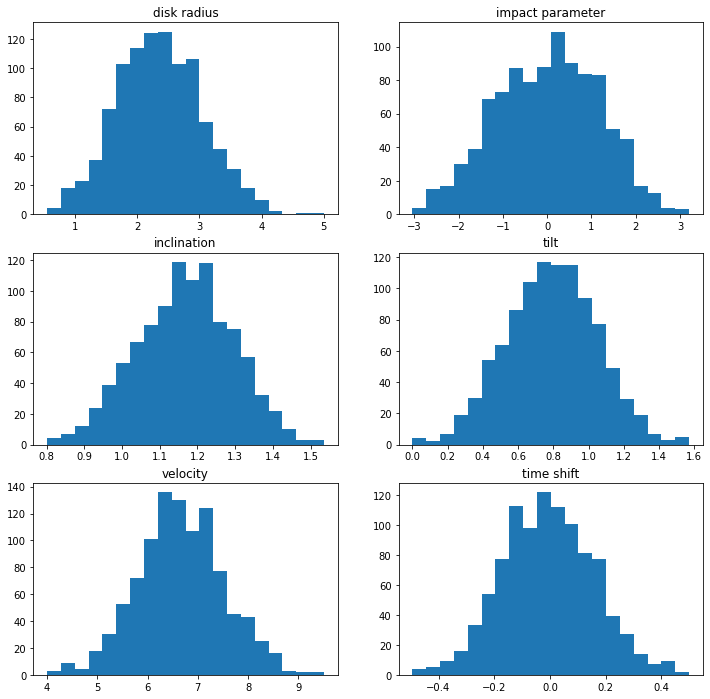

In [10]:
mcmc.plot_hist(p0_od, lbls=lbls_od)

In [17]:
# mcmc parameters
be_od = 'models/mcmc_backends/opaque_disk.h5'
args_od = (time, flux, error, opaque_disk, opaque_prior)
BE_od = emcee.backends.HDFBackend(be_od)

# run mcmc
p_od, sampler_od = mcmc.run_mcmc(*args_od, p0_od, 1000, reset=False, savename=be_od)

# load mcmc
sampler_od = emcee.EnsembleSampler(1000, 6, mcmc.lnprob, args=args_od, backend=BE_od)

100%|██████████| 700/700 [13:47:56<00:00, 70.97s/it]  


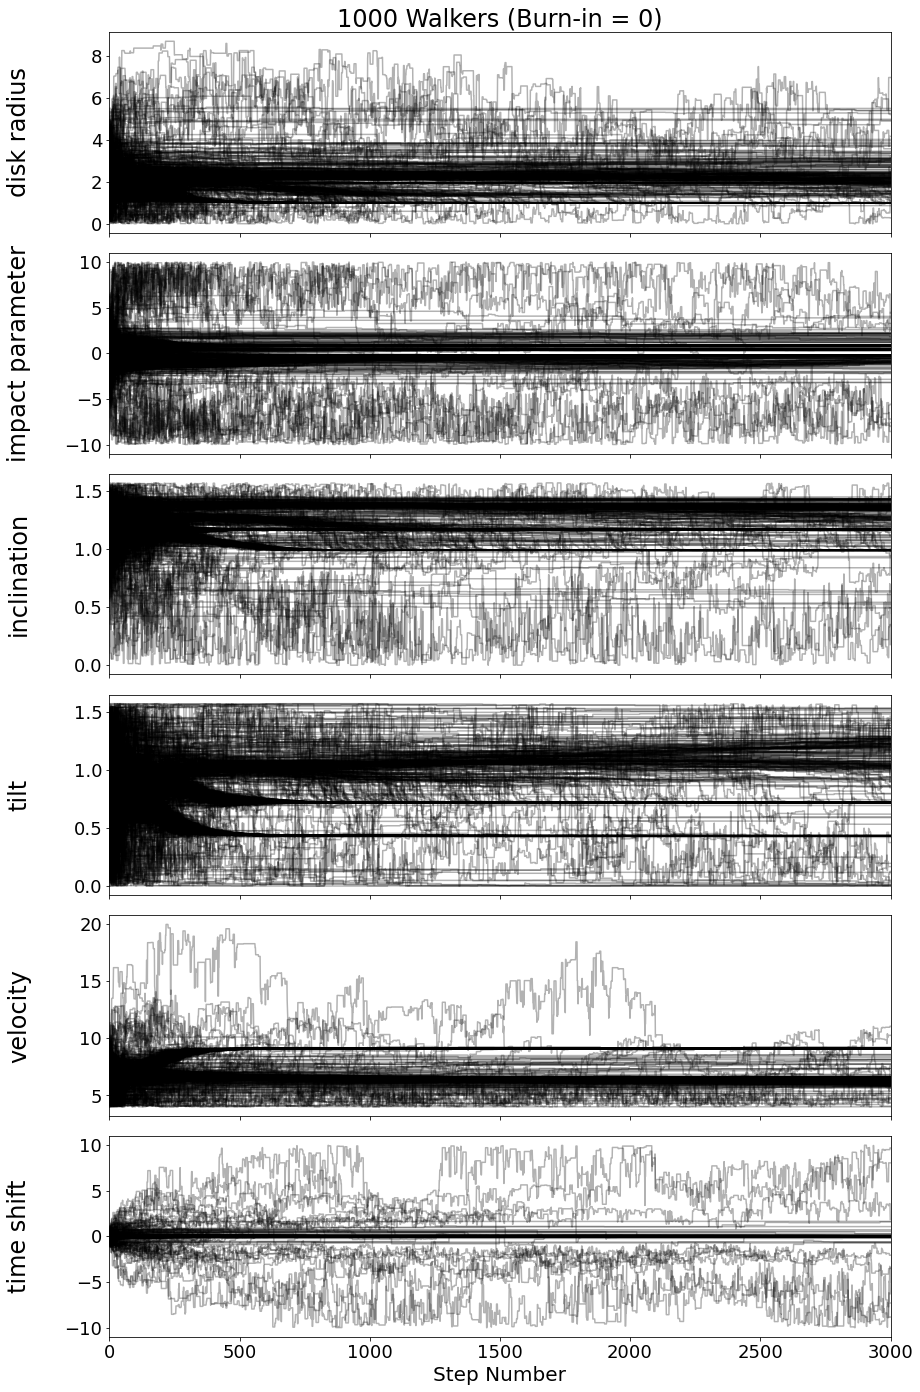

In [18]:
mcmc.plot_walkers(sampler_od, lbls=lbls_od)

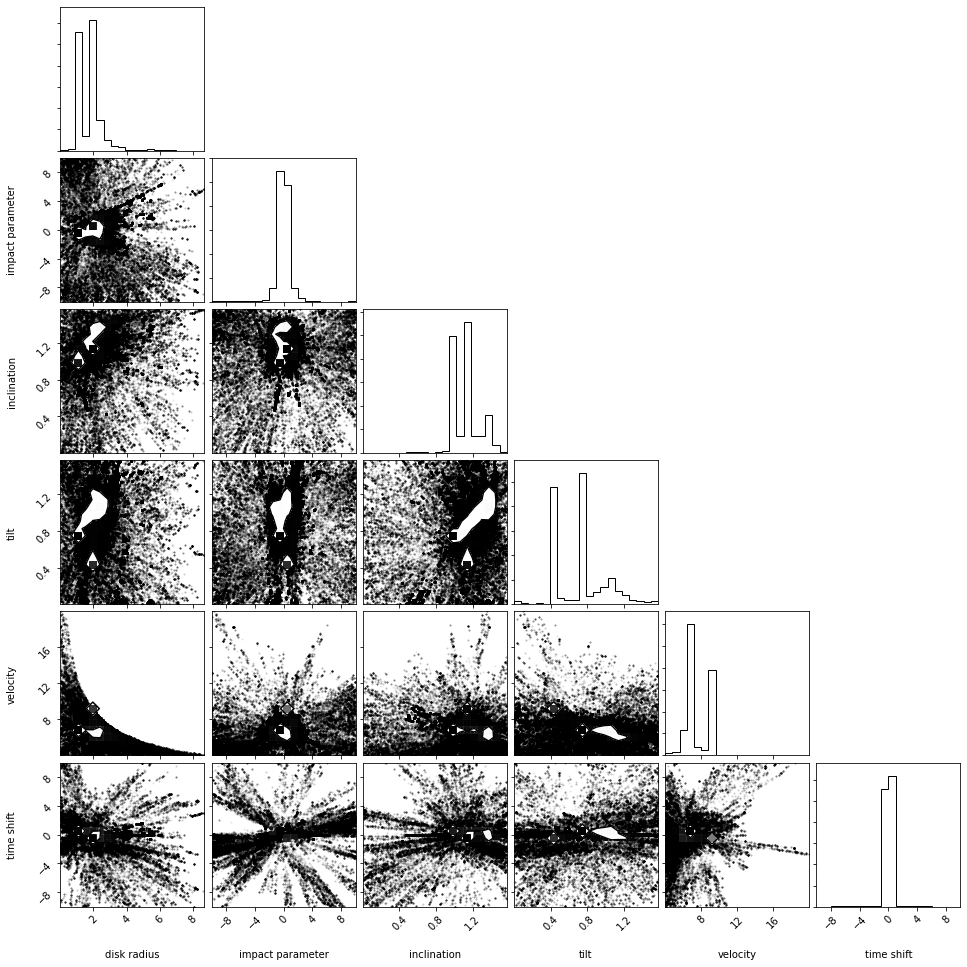

In [19]:
mcmc.plot_triangle(sampler_od, lbls=lbls_od)

## Translucent Disk

In [6]:
lbls_td = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 
           'time shift', 'disk opacity']
units_td = ['R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-']
bounds_td = [(rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), 
             (-0.5, 0.5), (Tu/2., Tu)]

pargs_td = (7, 1000, bounds_td)
p0_td = eclipse.useful_p0(mcmc.bounded_p0, pargs_td, translucent_disk, time, False, 4)


  1%|          | 8/1000 [00:00<00:12, 76.81it/s]

round 1 from 0 to 761 (max = 1000)


  0%|          | 4/1000 [00:00<00:36, 27.57it/s]

round 2 from 761 to 1000 (max = 1000)


  3%|▎         | 7/263 [00:00<00:03, 67.03it/s]

ran a for loop
USEFUL ROUND 1 FROM 0 TO 737 (MAX = 1000)



  3%|▎         | 8/263 [00:00<00:03, 71.90it/s]

round 1 from 0 to 180 (max = 263)


  1%|          | 2/263 [00:00<00:17, 14.98it/s]

round 2 from 180 to 263 (max = 263)


 11%|█         | 7/65 [00:00<00:00, 68.11it/s]

ran a for loop
USEFUL ROUND 2 FROM 737 TO 935 (MAX = 1000)



  0%|          | 0/65 [00:00<?, ?it/s]

round 1 from 0 to 57 (max = 65)
round 2 from 57 to 65 (max = 65)


 41%|████      | 7/17 [00:00<00:00, 61.11it/s]

ran a for loop
USEFUL ROUND 3 FROM 935 TO 983 (MAX = 1000)



  6%|▌         | 1/17 [00:00<00:01,  9.64it/s]

round 1 from 0 to 15 (max = 17)
round 2 from 15 to 17 (max = 17)


  0%|          | 0/1 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 4 FROM 983 TO 998 (MAX = 1000)

round 1 from 0 to 2 (max = 2)
ran a for loop
USEFUL ROUND 5 FROM 998 TO 999 (MAX = 1000)

round 1 from 0 to 1 (max = 1)
ran a for loop
round 1 from 0 to 1 (max = 1)


  0%|          | 0/1 [00:00<?, ?it/s]

ran a for loop
USEFUL ROUND 6 FROM 999 TO 1000 (MAX = 1000)



In [ ]:
mcmc.plot_hist(p0_td, lbls=lbls_td)

In [ ]:
# mcmc parameters
be_td = 'models/mcmc_backends/translucent_disk.h5'
args_td = (time, flux, error, translucent_disk, translucent_prior)
BE_td = emcee.backends.HDFBackend(be_td)

# run mcmc
#p_td, sampler_td = mcmc.run_mcmc(*args_td, p0_td, 1500, reset=False, savename=be_td)

# load mcmc
sampler_td = emcee.EnsembleSampler(1000, 7, mcmc.lnprob, args=args_td, backend=BE_td)


In [ ]:
mcmc.plot_walkers(sampler_td, lbls=lbls_td)

In [ ]:
mcmc.plot_triangle(s_td, lbls=lbls_td, cut=0)

In [ ]:
ps_td = mcmc.plot_samples(time, flux, error, [translucent_disk], [sampler_td], 
                          lbls=lbls_td, cut=2000, num=500, residual_lims=(-0.08,0.08))

In [ ]:
ss_td = mcmc.extract_solutions(sampler_td, [4, 4],[(0, 8), (8, 20)], lbls=lbls_td)

In [ ]:
ss0_td = mcmc.extract_solutions(ss_td[0], [0,0],[(0, 1.5), (1.5, 20)], lbls=lbls_td)

In [ ]:
mcmc.plot_triangle(ss0_td[0], lbls=lbls_td, cut=1000)

In [ ]:
mcmc.plot_triangle(ss_td[1], lbls=lbls_td, cut=500)

In [ ]:
stats_td0, pb_td0 = mcmc.stats(ss0_td[0], cut=1000)
stats_td1, pb_td1 = mcmc.stats(ss_td[1], cut=500)
print('vel < 8 and Rd < 1.5')
mcmc.print_parameters(pb_td0, lbls_td, units_td)
print('')
print('vel > 8')
mcmc.print_parameters(pb_td1, lbls_td, units_td)

In [ ]:
pb_old = np.load('/Users/dmvandam/SurfDrive/phd/projects/v928tau/models/eclipse_model_hlm.npy')
mcmc.plot_models(time, flux, error, 3*[translucent_disk], [pb_td0, pb_td1, pb_old], 
                 lbls=['new slow','new fast','old'], residual_lims=(-0.08,0.08), dt=3002)

## Fuzzy Disk

In [24]:
lbls_fd = ['disk radius', 'edge thickness', 'impact parameter', 'inclination', 'tilt', 
           'velocity', 'time shift', 'disk opacity', 'edge opacity']
units_fd = ['R*', 'R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-', '-']
bounds_fd = [(rl, ru/2.), (rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), 
             (-0.5, 0.5), (Tu/2., Tu), (Tl, Tu/2.)]

args_fd = (9, 1000, pref_bounds_fd)
p0_fd = eclipse.useful_p0(mcmc.bounded_p0, args_fd, fuzzy_disk, time, True, 5)


  1%|          | 8/1000 [00:00<00:13, 72.76it/s]

round 1 from 0 to 157 (max = 1000)


  1%|          | 8/1000 [00:00<00:13, 72.67it/s]

round 2 from 157 to 287 (max = 1000)


  1%|          | 9/1000 [00:00<00:11, 83.08it/s]

round 3 from 287 to 428 (max = 1000)


  1%|          | 7/1000 [00:00<00:14, 68.34it/s]

round 4 from 428 to 568 (max = 1000)


  1%|          | 7/1000 [00:00<00:15, 62.26it/s]

round 5 from 568 to 693 (max = 1000)


  1%|          | 8/1000 [00:00<00:13, 73.28it/s]

round 6 from 693 to 842 (max = 1000)


  0%|          | 1/1000 [00:00<02:13,  7.48it/s]

round 7 from 842 to 1000 (max = 1000)


  5%|▍         | 8/161 [00:00<00:02, 71.72it/s]

ran a for loop
USEFUL ROUND 1 FROM 0 TO 839 (MAX = 1000)



  5%|▍         | 8/161 [00:00<00:02, 72.39it/s]

round 1 from 0 to 29 (max = 161)


  5%|▍         | 8/161 [00:00<00:02, 73.05it/s]

round 2 from 29 to 50 (max = 161)


  5%|▍         | 8/161 [00:00<00:02, 74.54it/s]

round 3 from 50 to 69 (max = 161)


  4%|▍         | 7/161 [00:00<00:02, 66.86it/s]

round 4 from 69 to 88 (max = 161)


  4%|▍         | 7/161 [00:00<00:02, 65.76it/s]

round 5 from 88 to 111 (max = 161)


  4%|▍         | 7/161 [00:00<00:02, 65.91it/s]

round 6 from 111 to 129 (max = 161)


  4%|▍         | 7/161 [00:00<00:02, 67.64it/s]

round 7 from 129 to 150 (max = 161)


  0%|          | 0/161 [00:00<?, ?it/s]

round 8 from 150 to 161 (max = 161)


 28%|██▊       | 7/25 [00:00<00:00, 69.75it/s]

ran a for loop
USEFUL ROUND 2 FROM 839 TO 975 (MAX = 1000)



 32%|███▏      | 8/25 [00:00<00:00, 72.70it/s]

round 1 from 0 to 5 (max = 25)


 32%|███▏      | 8/25 [00:00<00:00, 72.39it/s]

round 2 from 5 to 8 (max = 25)


 32%|███▏      | 8/25 [00:00<00:00, 72.24it/s]

round 3 from 8 to 11 (max = 25)


 32%|███▏      | 8/25 [00:00<00:00, 75.34it/s]

round 4 from 11 to 16 (max = 25)


 28%|██▊       | 7/25 [00:00<00:00, 63.90it/s]

round 5 from 16 to 19 (max = 25)


  0%|          | 0/25 [00:00<?, ?it/s]

round 6 from 19 to 24 (max = 25)
round 7 from 24 to 25 (max = 25)


 50%|█████     | 1/2 [00:00<00:00, 31.41it/s]

ran a for loop
USEFUL ROUND 3 FROM 975 TO 998 (MAX = 1000)

round 1 from 0 to 1 (max = 2)



 50%|█████     | 1/2 [00:00<00:00,  8.00it/s]

round 2 from 1 to 2 (max = 2)
ran a for loop
USEFUL ROUND 4 FROM 998 TO 1000 (MAX = 1000)



In [ ]:
# mcmc parameters
be_fd = 'models/eclipse/fuzzy_disk.h5'
mcmc_args_fd = (time, flux, error, fuzzy_disk, fuzzy_prior)
BE_fd = emcee.backends.HDFBackend(be_fd)

# run mcmc
p_fd, sampler_fd = mcmc.run_mcmc(*mcmc_args_fd, p0_fd, 500, reset=False, savename=be_fd)

# load mcmc
sampler_fd = emcee.EnsembleSampler(1000, 9, mcmc.lnprob, args=mcmc_args_fd, backend=BE_fd)

 22%|██▏       | 111/500 [3:09:12<10:59:51, 101.78s/it]

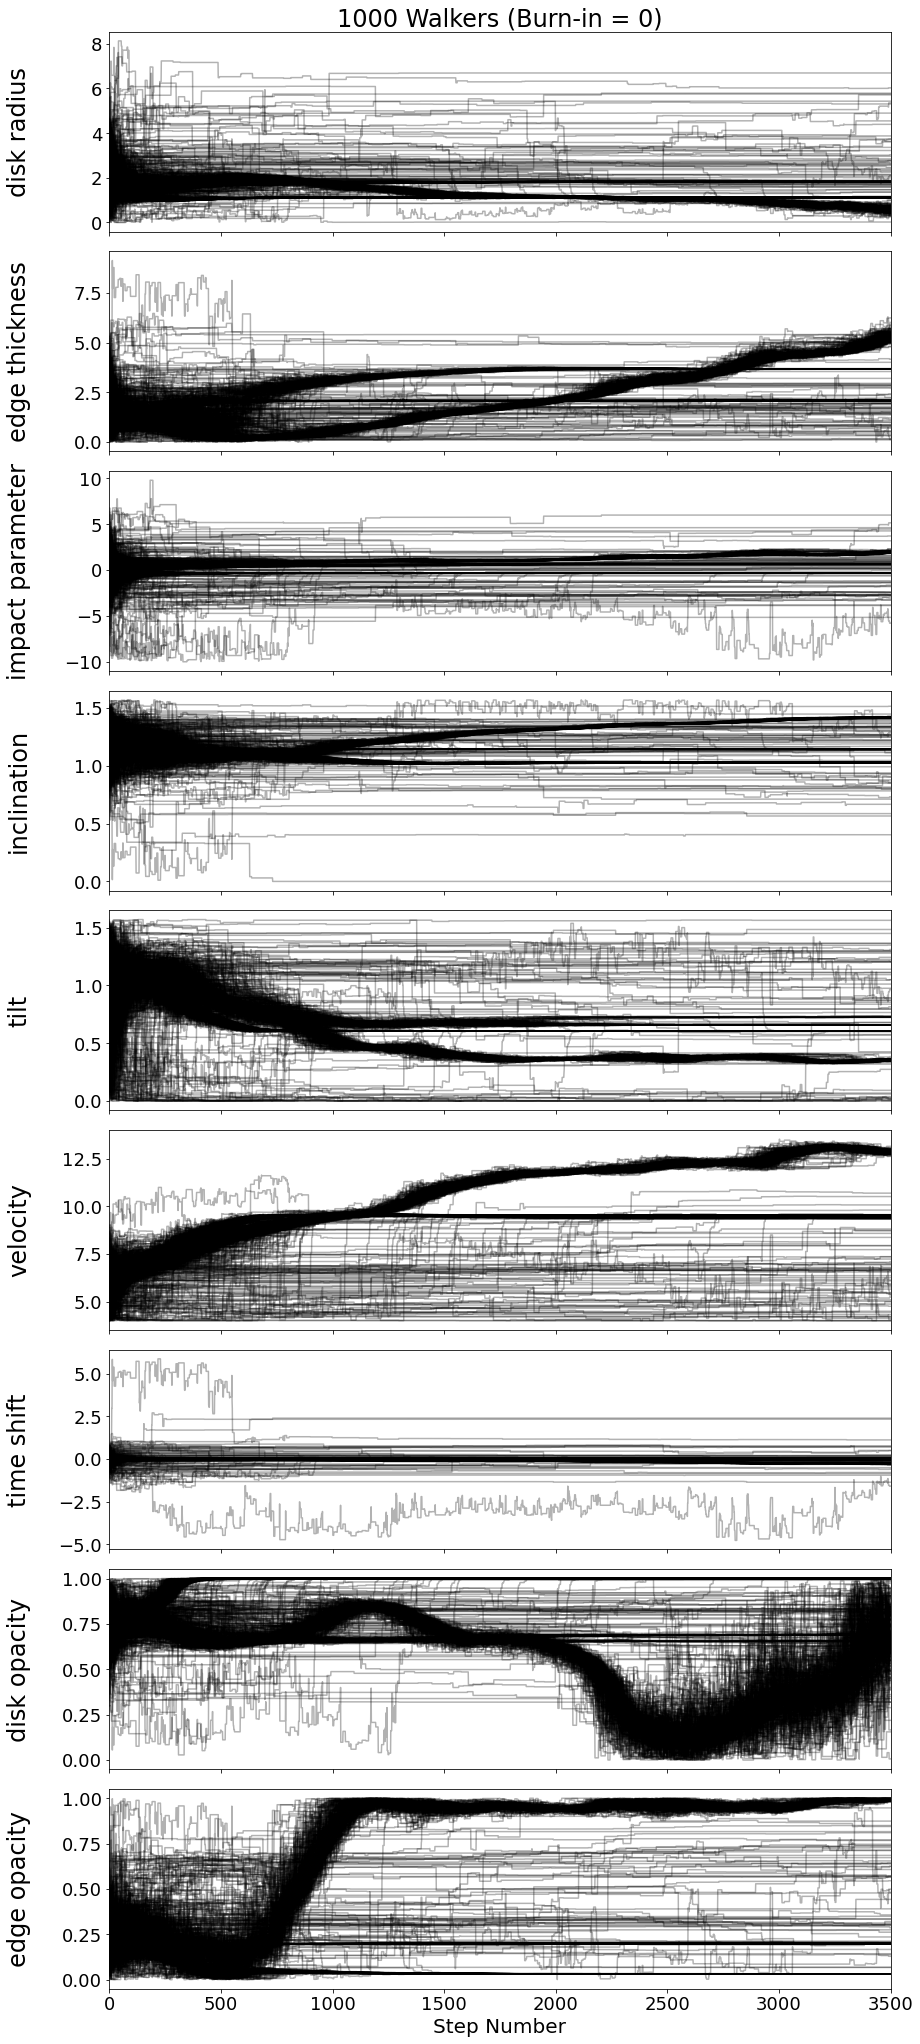

In [22]:
mcmc.plot_walkers(sampler_fd, lbls=lbls_fd)

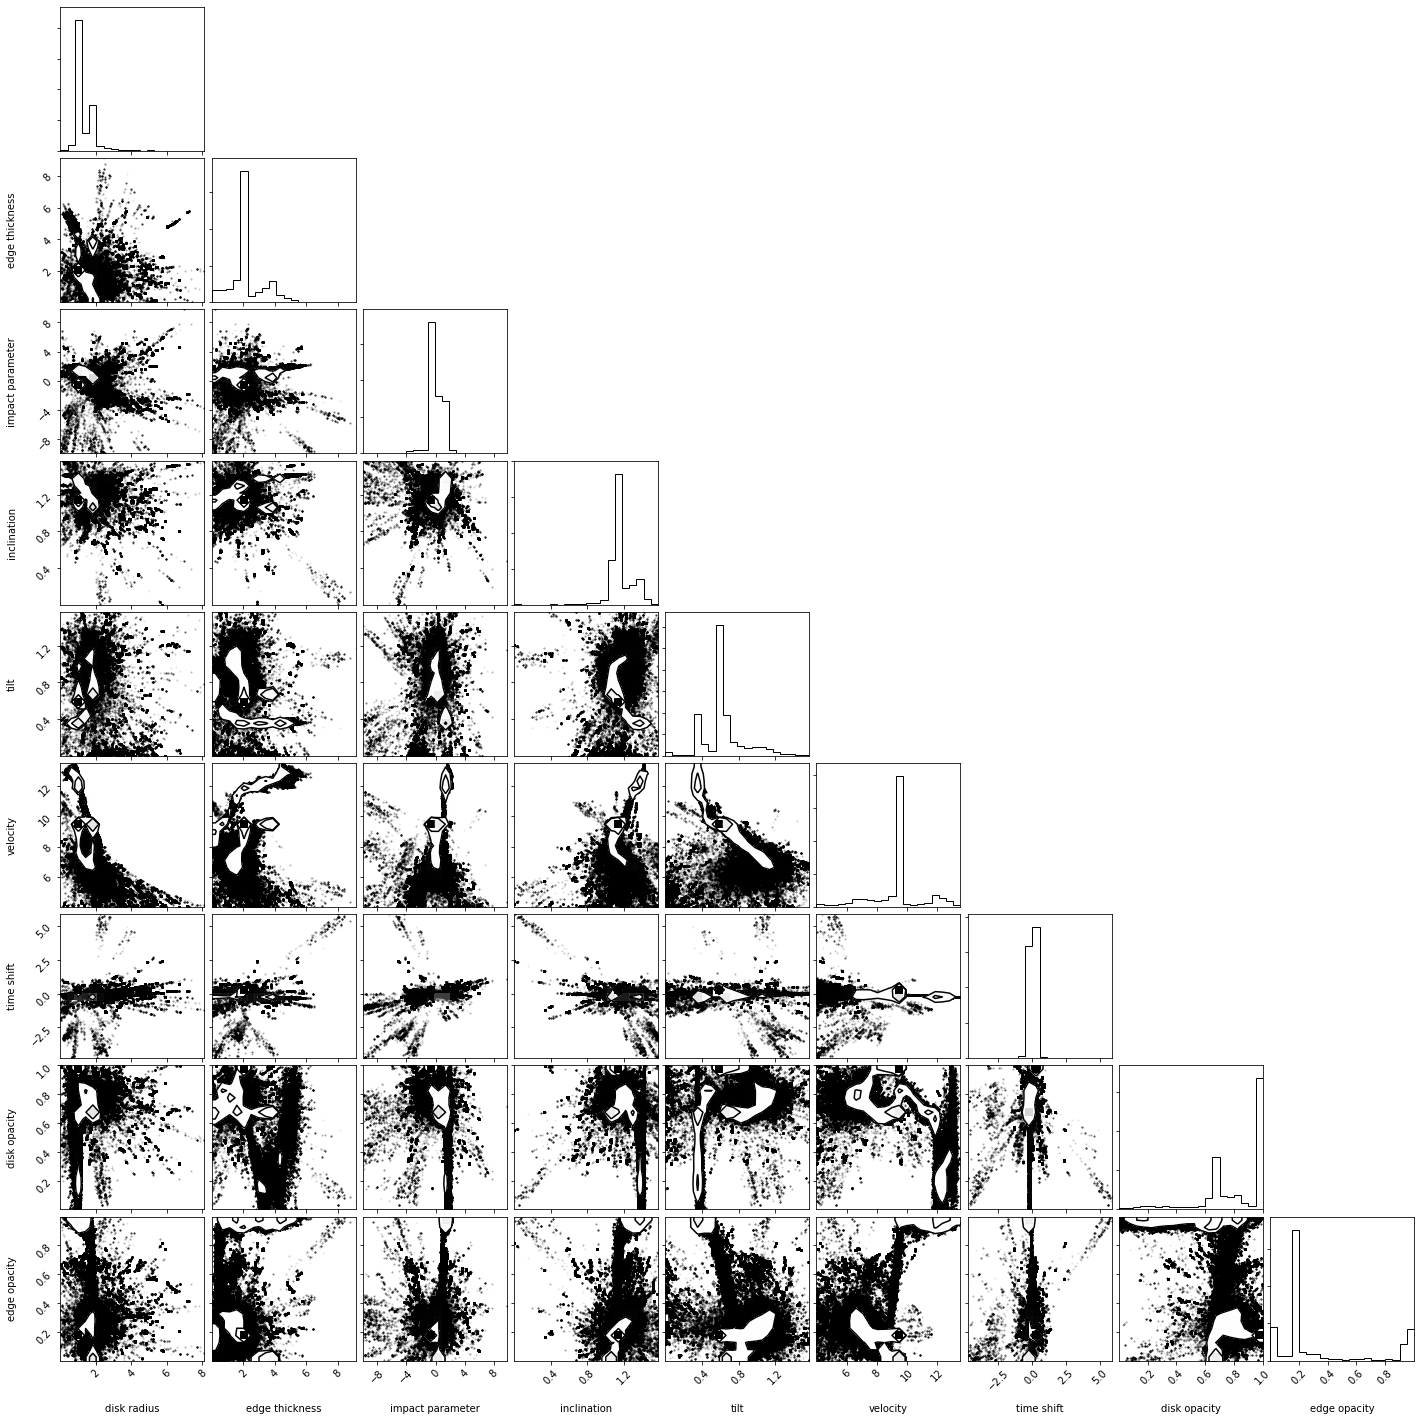

In [23]:
mcmc.plot_triangle(sampler_fd, lbls=lbls_fd)